<a href="https://colab.research.google.com/github/adhish-bahl/2347203_NNDL_Lab/blob/main/2347203_ETE3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Importing Libraries**

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error

#### **Mounting Drive**

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Importing Dataset**

In [41]:
data = pd.read_csv('/content/drive/MyDrive/Trimester5/NNDL/Lab/LabTest2/weather_data.csv')

In [42]:
print("Dataset Overview:")
print(data.head(10))

Dataset Overview:
         date  temperature
0  2014-01-01    10.248357
1  2014-01-02     9.950428
2  2014-01-03    10.362958
3  2014-01-04    10.820167
4  2014-01-05     9.961091
5  2014-01-06     9.980585
6  2014-01-07    10.906708
7  2014-01-08    10.520223
8  2014-01-09     9.921119
9  2014-01-10    10.446428


In [43]:
print("Dataset Information:")
print(data.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2557 non-null   object 
 1   temperature  2557 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.1+ KB
None


**Intepretation:** The above output means that the dataset has no null value, which is really good and hence no need to handle null values in the data pre-processing.

In [44]:
print("Dataset Columns:")
print(data.columns)

Dataset Columns:
Index(['date', 'temperature'], dtype='object')


#### **Preprocess the Data**

**Converting date column**

In [45]:
data['date'] = pd.to_datetime(data['date'])

Converting the "date" column to datetime format for easier use in the future tasks.

**Normalize the temperature data**

In [46]:
temperature = data['temperature'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled = scaler.fit_transform(temperature)

Normalizing the "temperature" column values within a range of [0, 1] using MinMaxScaler function. In LSTM, Normalization is required so that all the features contribute equally to the model.

**Split into training and testing sets**


In [47]:
train_data, test_data = train_test_split(temperature_scaled, test_size=0.2, random_state=42, shuffle=False)

The dataset is split into training (80%) and testing (20%) sets.

#### **Build an LSTM Autoencoder**

**Prepare the data for LSTM**

In [48]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 60
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

#### **Build the LSTM Autoencoder**

In [49]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 60, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 60, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 60, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 60, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

The encoder compresses input sequences into a latent representation.

The decoder reconstructs the original sequence from the latent representation.

#### **Train the Model**

In [50]:
history = model.fit(train_sequences, train_sequences,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    shuffle=False)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - loss: 0.1630 - val_loss: 0.0212
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0172 - val_loss: 0.0115
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - loss: 0.0076 - val_loss: 0.0057
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - loss: 0.0059 - val_loss: 0.0211
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120

**Plot training and validation loss**

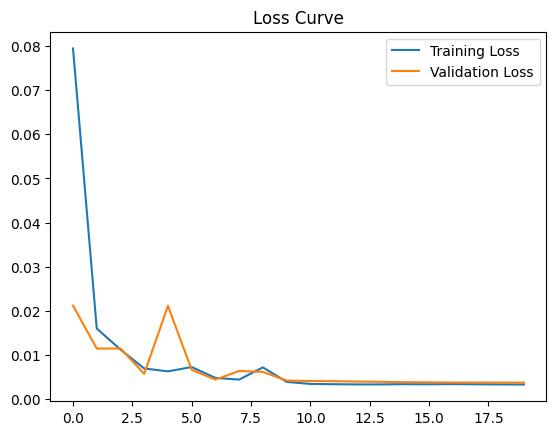

In [51]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

**Intepretation:**

The trainning of the model seems to be really good as the losses reduces as we move towards positive side of the x axis. The model has also reconstructed the model really well.

Since the trainning loss and validation loss are really close to each other which means that good prediction is being done by the model.

**Evaluate the reconstruction error on test set**

In [52]:
test_predictions = model.predict(test_sequences)
test_mse = np.mean(np.power(test_sequences - test_predictions, 2), axis=(1, 2))

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


#### **Anomaly Detection**

**Determine threshold for anomaly detection**

In [53]:
threshold = np.percentile(test_mse, 95)
print(f"Anomaly Detection Threshold: {threshold}")

Anomaly Detection Threshold: 0.0048158272082072665


**Intepretation:** The value of "Anomaly Detection Threshold" is really low which is a good sign for the algorithm.

Sequences with reconstruction errors (MSE) less than or equal to "Anomaly Detection Threshold" are considered normal.

Sequences with reconstruction errors (MSE) more than "Anomaly Detection Threshold" are flagged as anomalies.

**Identify anomalies**


In [54]:
anomalies = test_mse > threshold
anomalous_days = data.iloc[len(train_data) + sequence_length:][anomalies]

print(f"Number of Anomalies Detected: {len(anomalous_days)}")
print("Anomalous Days:")
print(anomalous_days)

Number of Anomalies Detected: 23
Anomalous Days:
           date  temperature
2284 2020-04-03    10.409633
2285 2020-04-04    10.887743
2286 2020-04-05    11.063033
2287 2020-04-06    10.559938
2288 2020-04-07    10.401058
2289 2020-04-08    11.424837
2290 2020-04-09    11.596668
2291 2020-04-10    11.229934
2292 2020-04-11    10.796168
2293 2020-04-12    10.362092
2294 2020-04-13    10.363425
2297 2020-04-16    11.514908
2298 2020-04-17    11.150537
2301 2020-04-20    10.357980
2303 2020-04-22    11.001610
2306 2020-04-25    11.206597
2307 2020-04-26    10.819858
2308 2020-04-27    11.186582
2309 2020-04-28    11.370678
2310 2020-04-29    10.773683
2312 2020-05-01    11.062310
2314 2020-05-03    11.292045
2318 2020-05-07    10.699128


**Intepretation:** The above 23 rows have reconstruction errors (MSE) more than "Anomaly Detection Threshold" we calculated and hence they are marked as Anomaly from the dataset.

#### **Visualize the Results**

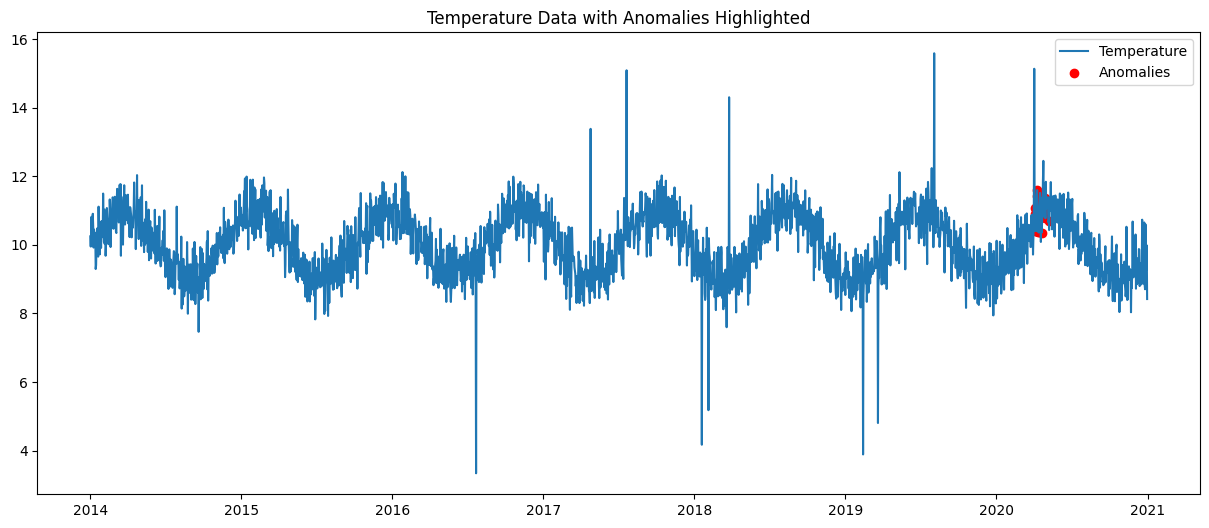

In [55]:
plt.figure(figsize=(15, 6))
plt.plot(data['date'], data['temperature'], label='Temperature')
plt.scatter(anomalous_days['date'], anomalous_days['temperature'], color='red', label='Anomalies')
plt.legend()
plt.title('Temperature Data with Anomalies Highlighted')
plt.show()

**Intepretation:**

The graph displays temperature readings over time, with anomalies marked by red dots.

Sudden changes in weather. Incorrect data points in the dataset. Rare and unexpected weather chnages are marked as anomalies.